In [1]:
# Initialization boilerplate
from typing import *

import os
import ibm_watson
import ibm_watson.natural_language_understanding_v1 as nlu
import ibm_cloud_sdk_core
import pandas as pd
import text_extensions_for_pandas as tp
import urllib

import ray
import spacy
import multiprocessing
import time
import threading
import matplotlib.pyplot as plt

api_key = os.environ.get("IBM_API_KEY")
service_url = os.environ.get("IBM_SERVICE_URL")  

import market_intelligence

# Part 4: Scale up some more with Pandas and Ray

TODO: Summarize parts 1-3


![First version of our processing pipeline](images/pipeline_v1.png)



In [2]:
import market_intelligence as mi
articles = mi.maybe_download_articles()
articles

,url,html
0,https://newsroom.ibm.com/2020-02-04-The-Avril-...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
1,https://newsroom.ibm.com/2020-02-11-IBM-X-Forc...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
2,https://newsroom.ibm.com/2020-02-18-IBM-Study-...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
3,https://newsroom.ibm.com/2020-02-19-IBM-Power-...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
4,https://newsroom.ibm.com/2020-02-20-Centotrent...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
...,...,...
186,https://newsroom.ibm.com/2021-01-25-OVHcloud-t...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
187,https://newsroom.ibm.com/2021-01-26-Luminor-Ba...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
188,https://newsroom.ibm.com/2021-01-26-DIA-Levera...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."
189,https://newsroom.ibm.com/2021-01-26-IBM-Board-...,"<!DOCTYPE html public ""-//W3C//DTD HTML 4.01 T..."


## Baseline: Process documents with a simple `for` loop.

At the end of Part 3, we showed how to run our pipeline with a simple `for` loop.

In [3]:
%%time

spacy_language_model = spacy.load("en_core_web_trf")
nlu_api = ibm_watson.NaturalLanguageUnderstandingV1(version="2021-01-01", 
            authenticator=ibm_cloud_sdk_core.authenticators.IAMAuthenticator(api_key))
nlu_api.set_service_url(service_url)

def steps_1_through_4(doc_html: str) -> pd.DataFrame:
    step_1_results = mi.extract_named_entities_and_semantic_roles(doc_html, nlu_api)
    step_2_results = mi.identify_persons_quoted_by_name(step_1_results)   
    step_3_results = mi.perform_targeted_dependency_parsing(
                                                   step_2_results["person"],
                                                   spacy_language_model)
    step_4_results = mi.extract_titles_of_persons(step_2_results, step_3_results)
    return step_4_results

# Repeat steps 1-4 on every document
dataframes_to_stack = [
    steps_1_through_4(doc_html) for doc_html in articles["html"]
]

# Step 5: Merge the results across documents
step_5_results = pd.concat(dataframes_to_stack)
step_5_results

CPU times: user 1min 30s, sys: 1.26 s, total: 1min 31s
Wall time: 4min 34s


,person,title
0,"[1977, 1991): 'Wendi Whitmore'","[1993, 2040): 'Vice President, IBM X-Force Thr..."
0,"[1281, 1292): 'Rob DiCicco'","[1294, 1348): 'PharmD, Deputy Chief Health Off..."
0,"[1213, 1229): 'Christoph Herman'","[1231, 1281): 'SVP and Head of SAP HANA Enterp..."
1,"[2227, 2242): 'Stephen Leonard'","[2244, 2282): 'General Manager, IBM Cognitive ..."
0,"[2290, 2298): 'Bob Lord'","[2300, 2376): 'IBM Senior Vice President of Co..."
...,...,...
1,"[2119, 2134): 'James Kavanaugh'","[2136, 2189): 'IBM senior vice president and c..."
0,"[3113, 3123): 'Mike Doran'","[3125, 3156): 'Worldwide Sales Director at IBM'"
0,"[3156, 3170): 'Howard Boville'","[3172, 3211): 'Senior Vice President, IBM Hybr..."
0,"[3511, 3525): 'Hillery Hunter'","[3527, 3558): 'IBM Fellow, VP & CTO, IBM Cloud'"


This code ran in about 4 1/2 minutes, a 3x improvement from the start of Part 3.

Now it's time to deploy parallel processing and improve that performance some more.

## First version: Wrap the entire processing pipeline in a `@ray.remote` decorator.

Let's use [Ray](https://ray.io) to parallelize our document processing steps.

TODO: Intro to Ray

as you tune the accuracy of an NLP application, you'll move between different scales

from examining results on individual documents on your laptop

to processing dozens of documents on your laptop

to processing thousands of documents on a server

to processing millions of documents on a cluster

and back again to your laptop for the next round of tuning

Ray lets you code up your processing pipeline once and have it work well across this wide variety of scales.


The first step is to start up a Ray cluster by calling `ray.init()`.

In [4]:
def reboot_ray():
    if ray.is_initialized():
        ray.shutdown()
    ray.init()
    
reboot_ray()

2021-05-18 17:03:31,861	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265


Now let's try the simplest approach possible: Wrap our document processing code in a Ray remote function. To create a remote function, we just need to define a Python function and add the `@ray.remote` decorator to the function:

In [5]:
# NOTE: The blog version of this cell should show this code side-by-side with the 
#  original code and highlight the changes.

spacy_language_model = spacy.load("en_core_web_trf")
nlu_api = ibm_watson.NaturalLanguageUnderstandingV1(version="2021-01-01", 
            authenticator=ibm_cloud_sdk_core.authenticators.IAMAuthenticator(api_key))
nlu_api.set_service_url(service_url)

# @ray.remote decorator defines a Ray task
@ray.remote
def steps_1_through_4(doc_html: str) -> pd.DataFrame:
    step_1_results = mi.extract_named_entities_and_semantic_roles(doc_html, nlu_api)
    step_2_results = mi.identify_persons_quoted_by_name(step_1_results)   
    step_3_results = mi.perform_targeted_dependency_parsing(
                                                   step_2_results["person"],
                                                   spacy_language_model)
    step_4_results = mi.extract_titles_of_persons(step_2_results, step_3_results)
    return step_4_results



Now we can push the processing of a document to the Ray cluster by spawning a copy of the remote function. To spawn a copy of the function, we call the remote function's `remote()` method, which starts running the function in the background and returns a *future* -- a placeholder for the result that the function will produce when it completes.

If we pass the future to `ray.get()`, then Ray will block until the function has completed, download the result to the calling process, and return the result:

In [6]:
doc_html = articles.iloc[1]["html"]

future = steps_1_through_4.remote(doc_html)
step_4_results = ray.get(future)

TypeError: can't pickle _thread.RLock objects

oops, can't pickle a connection to Watson NLU -- it has open sockets and lock objects

also can't pickle the language model inside the SpaCy dependency parser
(as of SpaCy version 3.0).
and even if you could, it's a 500 megabyte model.

To make this work, we'll need to pull the initialization code inside the Ray task:

In [7]:
@ray.remote
def steps_1_through_4(doc_html: str) -> pd.DataFrame:
    spacy_language_model = spacy.load("en_core_web_trf")
    nlu_api = ibm_watson.NaturalLanguageUnderstandingV1(version="2021-01-01", 
            authenticator=ibm_cloud_sdk_core.authenticators.IAMAuthenticator(api_key))
    nlu_api.set_service_url(service_url)
    
    step_1_results = mi.extract_named_entities_and_semantic_roles(doc_html, nlu_api)
    step_2_results = mi.identify_persons_quoted_by_name(step_1_results)   
    step_3_results = mi.perform_targeted_dependency_parsing(
                                                   step_2_results["person"],
                                                   spacy_language_model)
    step_4_results = mi.extract_titles_of_persons(step_2_results, step_3_results)
    return step_4_results


Now our Ray task works on a single document:

In [8]:
step_4_results = ray.get(steps_1_through_4.remote(doc_html))
step_4_results

,person,title
0,"[1977, 1991): 'Wendi Whitmore'","[1993, 2040): 'Vice President, IBM X-Force Thr..."


To process our entire collection of documents, we modify our `for` loop so that it spawns background tasks for each of the documents instead of processing the documents locally. Then we wrap the `for` loop in a call to `ray.get()`, which tells Ray to wait until all the background tasks have completed and collect the results:

In [9]:
reboot_ray()

2021-05-18 17:28:20,508	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265


In [10]:
%%time

# NOTE: The blog version of this listing should highlight what has changed 
#  relative to the original code.

@ray.remote
def steps_1_through_4(doc_html: str) -> pd.DataFrame:
    nlu_api = ibm_watson.NaturalLanguageUnderstandingV1(version="2021-01-01", 
            authenticator=ibm_cloud_sdk_core.authenticators.IAMAuthenticator(api_key))
    nlu_api.set_service_url(service_url)
    spacy_language_model = spacy.load("en_core_web_trf")
    
    step_1_results = mi.extract_named_entities_and_semantic_roles(doc_html, nlu_api)
    step_2_results = mi.identify_persons_quoted_by_name(step_1_results)   
    step_3_results = mi.perform_targeted_dependency_parsing(
                                                   step_2_results["person"],
                                                   spacy_language_model)
    step_4_results = mi.extract_titles_of_persons(step_2_results, step_3_results)
    return step_4_results

# Repeat steps 1-4 on every document, at the same time
dataframes_to_stack = ray.get([
    steps_1_through_4.remote(doc_html) for doc_html in articles["html"]
])

# Step 5: Merge the results across documents
step_5_results = pd.concat(dataframes_to_stack)
step_5_results

(pid=17001) Request failed 1 times; retrying in 1 sec
(pid=17001) Request failed 1 times; retrying in 1 sec
(pid=17000) Request failed 1 times; retrying in 1 sec
(pid=17000) Request failed 1 times; retrying in 1 sec
(pid=16999) Request failed 1 times; retrying in 1 sec
(pid=16999) Request failed 1 times; retrying in 1 sec
(pid=16991) Request failed 1 times; retrying in 1 sec
(pid=16991) Request failed 1 times; retrying in 1 sec
(pid=17000) Request failed 1 times; retrying in 1 sec
(pid=17000) Request failed 1 times; retrying in 1 sec
CPU times: user 4.65 s, sys: 1.44 s, total: 6.09 s
Wall time: 2min 20s


,person,title
0,"[1977, 1991): 'Wendi Whitmore'","[1993, 2040): 'Vice President, IBM X-Force Thr..."
0,"[1281, 1292): 'Rob DiCicco'","[1294, 1348): 'PharmD, Deputy Chief Health Off..."
0,"[1213, 1229): 'Christoph Herman'","[1231, 1281): 'SVP and Head of SAP HANA Enterp..."
1,"[2227, 2242): 'Stephen Leonard'","[2244, 2282): 'General Manager, IBM Cognitive ..."
0,"[2290, 2298): 'Bob Lord'","[2300, 2376): 'IBM Senior Vice President of Co..."
...,...,...
1,"[2119, 2134): 'James Kavanaugh'","[2136, 2189): 'IBM senior vice president and c..."
0,"[3113, 3123): 'Mike Doran'","[3125, 3156): 'Worldwide Sales Director at IBM'"
0,"[3156, 3170): 'Howard Boville'","[3172, 3211): 'Senior Vice President, IBM Hybr..."
0,"[3511, 3525): 'Hillery Hunter'","[3527, 3558): 'IBM Fellow, VP & CTO, IBM Cloud'"


This version actually works, and it runs in 1:35 on an 8-core laptop -- an additional performance improvement of almost 3x on top of the 3x improvement from Part 3.

But there's room for two kinds of additional improvement:
* This code loads a 500 megabyte model for every document, which incurs a signficant additional cost. The 8 cores on our test machine are fully occupied, but we only see a speedup of 3. So we're using more than twice as many CPU cycles per document.
* This code produces several screens of scary log messages like: 
  ```
  (pid=8210) ERROR:root:Too Many Requests
  (pid=8210) Traceback (most recent call last):
  (pid=8210)   File "/Users/freiss/pd/blogs-market/env/lib/python3.7/site-packages/ibm_cloud_sdk_core/base_service.py", line 225, in send
  (pid=8210)     response.status_code, http_response=response)
  (pid=8210) ibm_cloud_sdk_core.api_exception.ApiException: Error: Too Many Requests, Code: 429 , X-global-transaction-id: ded4dd39-a617-4ce2-9d54-26aa7a82ab95
  (pid=8210) Request failed 2 times; retrying in 2 sec
  ```
  because we're exceeding the request rate limit of our free Lite instance of Watson Natural Language Understanding. The limit for a Lite instance is 5 requests per second.
  We should be able to finish our 190 documents in 38 seconds while staying below the limit.
  But instead we're taking twice as long while continually bumping up against the limit and having to retry requests.
  
We can use Ray *actors* to address both of these problems.

## Using actors to avoid repeated model startup

A Ray *actor* is persistent Python or Java object that lives in a Ray worker process. Actors can maintain arbitrary amounts of state, both mutable and immutable. If we attach the SpaCy language model to an actor, then the model will be initialized once in the actor's constructor instead of being loaded each time we process a document.

Turning our `steps_1_through_4()` function into a Ray Actor is a simple matter of restructuring the code slightly.

Here's the code before using actor:
```python
@ray.remote
def steps_1_through_4(doc_html: str) -> pd.DataFrame:
    spacy_language_model = spacy.load("en_core_web_trf")
    nlu_api = ibm_watson.NaturalLanguageUnderstandingV1(version="2021-01-01", 
            authenticator=ibm_cloud_sdk_core.authenticators.IAMAuthenticator(api_key))
    nlu_api.set_service_url(service_url)
    
    step_1_results = mi.extract_named_entities_and_semantic_roles(doc_html, nlu_api)
    step_2_results = mi.identify_persons_quoted_by_name(step_1_results)   
    step_3_results = mi.perform_targeted_dependency_parsing(
                                                   step_1_results["analyzed_text"],
                                                   spacy_language_model)
    step_4_results = mi.extract_titles_of_persons(step_2_results, step_3_results)
    return step_4_results
```

And here's a version that uses an actor:

In [11]:
@ray.remote
class ParserModelActor(object):
    def __init__(self, spacy_model_name: str):
        self._language_model = spacy.load(spacy_model_name)
        self._nlu_api = ibm_watson.NaturalLanguageUnderstandingV1(version="2021-01-01", 
                authenticator=ibm_cloud_sdk_core.authenticators.IAMAuthenticator(api_key))
        self._nlu_api.set_service_url(service_url)

    def steps_1_through_4(self, doc_html: str) -> pd.DataFrame:
        step_1_results = mi.extract_named_entities_and_semantic_roles(doc_html, 
                                                                      self._nlu_api)
        step_2_results = mi.identify_persons_quoted_by_name(step_1_results)   
        step_3_results = mi.perform_targeted_dependency_parsing(
                                                       step_2_results["person"],
                                                       self._language_model)
        step_4_results = mi.extract_titles_of_persons(step_2_results, step_3_results)
        return step_4_results


Compared with the previous Ray task, this version makes two important changes:
* The model initializaiton in first line of `steps_1_through_4` moves to the class's constructor.
* We use the actor's local copy, `self._language_model`, as the input to the processing for step 3.

Invoking a Ray actor is a two-step process. First, you create an instance of the actor. Then you tell that instance to perform tasks.

Here's some code that creates an instance of the `ParserModelActor` Actor, invokes the actor's `steps_1_through_4` task, blocks until the task completes, and returns the results:

In [12]:
reboot_ray()

2021-05-18 17:30:47,242	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265


In [13]:
actor = ParserModelActor.remote("en_core_web_trf")
future = actor.steps_1_through_4.remote(doc_html)
step_4_results = ray.get(future)
step_4_results

,person,title
0,"[1977, 1991): 'Wendi Whitmore'","[1993, 2040): 'Vice President, IBM X-Force Thr..."


This code runs, performs the computation in the background, and produces the correct result. And the actor will remain active as long as the Python variable `actor` is still in scope. We can pass additional documents to the `steps_1_through_4` task without incurring the overhead of loading a language model each time.


In [14]:
reboot_ray()

2021-05-18 17:31:03,743	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265


In [15]:
%%time

# This listing should NOT appear in the blog version.
# Run a pool with the actor defined above over the entire document collection, just
# to make sure it works and to determine the running time.

num_cpus = multiprocessing.cpu_count() // 2

actors = ray.util.ActorPool([ParserModelActor.remote("en_core_web_trf")
                             for i in range(num_cpus)])

# Repeat steps 1-4 on every document
dataframes_to_stack = actors.map_unordered(
    lambda actor, value: actor.steps_1_through_4.remote(value), articles["html"]
)

# Step 5: Merge the results across documents
step_5_results = pd.concat(dataframes_to_stack)
step_5_results

(pid=17182) Request failed 1 times; retrying in 1 sec
(pid=17182) Request failed 1 times; retrying in 1 sec
(pid=17182) Request failed 1 times; retrying in 1 sec
(pid=17182) Request failed 1 times; retrying in 1 sec
(pid=17193) Request failed 1 times; retrying in 1 sec
(pid=17193) Request failed 1 times; retrying in 1 sec
(pid=17193) Request failed 1 times; retrying in 1 sec
(pid=17193) Request failed 1 times; retrying in 1 sec
(pid=17189) Request failed 1 times; retrying in 1 sec
(pid=17189) Request failed 1 times; retrying in 1 sec
(pid=17189) Request failed 1 times; retrying in 1 sec
(pid=17189) Request failed 1 times; retrying in 1 sec
(pid=17192) Request failed 1 times; retrying in 1 sec
(pid=17192) Request failed 1 times; retrying in 1 sec
(pid=17192) Request failed 1 times; retrying in 1 sec
(pid=17192) Request failed 1 times; retrying in 1 sec
(pid=17190) Request failed 1 times; retrying in 1 sec
(pid=17190) Request failed 1 times; retrying in 1 sec
(pid=17190) Request failed 1

,person,title
0,"[1281, 1292): 'Rob DiCicco'","[1294, 1348): 'PharmD, Deputy Chief Health Off..."
0,"[1597, 1605): 'Bob Lord'","[1607, 1673): 'Senior Vice President, Cognitiv..."
0,"[1213, 1229): 'Christoph Herman'","[1231, 1281): 'SVP and Head of SAP HANA Enterp..."
1,"[2227, 2242): 'Stephen Leonard'","[2244, 2282): 'General Manager, IBM Cognitive ..."
0,"[1289, 1303): 'Wendi Whitmore'","[1305, 1344): 'VP of Threat Intelligence, IBM ..."
...,...,...
0,"[315, 329): 'Arvind Krishna'","[331, 371): 'IBM chairman and chief executive ..."
1,"[2119, 2134): 'James Kavanaugh'","[2136, 2189): 'IBM senior vice president and c..."
0,"[3511, 3525): 'Hillery Hunter'","[3527, 3558): 'IBM Fellow, VP & CTO, IBM Cloud'"
0,"[3113, 3123): 'Mike Doran'","[3125, 3156): 'Worldwide Sales Director at IBM'"


## Using actors to manage request rate

The large model that we attached to our `ParserModelActor` actor is an example of *immutable* actor state. Ray actors can also have *mutable* state that changes in response to tasks that the actor performs.

We can use mutable actor state to track of how quickly our application is sending requests to the Watson Natural Language Understanding web service. One simple way to track the request rate is to remember the how much time has elapsed since the most recent request. With that information in hand, our actor can throttle new requests if they would exceed the rate limit.

We put the logic for managing this state into an abstract base class, `RateLimitedActor`, the code for which can be found in `market_intelligence.py`. With that base class in place, we can define a Ray actor that sends documents to the Watson Natural Language Understanding web service while respecting a request rate limit. Because the Python API for Watson Natural Language Understanding is thread-safe, we can use a multithreaded Python actor to track multiple simulataneous requests.

In [16]:
import importlib
mi = importlib.reload(mi)

In [17]:
@ray.remote
class NLUClientActor(mi.RateLimitedActor):
    """
    Threaded actor to handle multiple simulatenous requests to the IBM Watson
    Natural Language Understanding service while respecting an upper bound on the
    number of requests per second.
    """
    def __init__(self, requests_per_sec: float, 
                 api_key: str, service_url: str):
        super().__init__(requests_per_sec)
        # One instance of the Python API for all threads
        self._nlu_api = ibm_watson.NaturalLanguageUnderstandingV1(
            version="2021-01-01", 
            authenticator=ibm_cloud_sdk_core.authenticators.IAMAuthenticator(api_key))
        self._nlu_api.set_service_url(service_url)
    
    def process_internal(self, doc_html: str) -> Any:
        return mi.extract_named_entities_and_semantic_roles(doc_html, self._nlu_api)

In [18]:
@ray.remote
class ParserModelActor(object):
    def __init__(self, spacy_model_name: str, nlu_client: NLUClientActor):
        self._language_model = spacy.load(spacy_model_name)
        self._nlu_client = nlu_client

    def steps_1_through_4(self, doc_html: str) -> pd.DataFrame:
        step_1_results = ray.get(self._nlu_client.process.remote(doc_html))
        step_2_results = mi.identify_persons_quoted_by_name(step_1_results)   
        step_3_results = mi.perform_targeted_dependency_parsing(
                                                       step_2_results["person"],
                                                       self._language_model)
        step_4_results = mi.extract_titles_of_persons(step_2_results, step_3_results)
        return step_4_results


In [19]:
reboot_ray()

2021-05-18 17:32:06,050	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265


In [20]:
%%time

num_cpus = multiprocessing.cpu_count() // 2

nlu_client = NLUClientActor.options(max_concurrency=5).remote(5.0, api_key, service_url)
actors = ray.util.ActorPool([ParserModelActor.remote("en_core_web_trf", nlu_client)
                             for i in range(num_cpus)])

dataframes_to_stack = actors.map_unordered(
    lambda actor, value: actor.steps_1_through_4.remote(value), 
    articles["html"]
)

step_5_results = pd.concat(dataframes_to_stack)
step_5_results

CPU times: user 1.59 s, sys: 575 ms, total: 2.16 s
Wall time: 55.1 s


,person,title
0,"[1213, 1229): 'Christoph Herman'","[1231, 1281): 'SVP and Head of SAP HANA Enterp..."
1,"[2227, 2242): 'Stephen Leonard'","[2244, 2282): 'General Manager, IBM Cognitive ..."
0,"[1281, 1292): 'Rob DiCicco'","[1294, 1348): 'PharmD, Deputy Chief Health Off..."
0,"[1977, 1991): 'Wendi Whitmore'","[1993, 2040): 'Vice President, IBM X-Force Thr..."
0,"[1289, 1303): 'Wendi Whitmore'","[1305, 1344): 'VP of Threat Intelligence, IBM ..."
...,...,...
0,"[3156, 3170): 'Howard Boville'","[3172, 3211): 'Senior Vice President, IBM Hybr..."
0,"[315, 329): 'Arvind Krishna'","[331, 371): 'IBM chairman and chief executive ..."
1,"[2119, 2134): 'James Kavanaugh'","[2136, 2189): 'IBM senior vice president and c..."
0,"[3511, 3525): 'Hillery Hunter'","[3527, 3558): 'IBM Fellow, VP & CTO, IBM Cloud'"


Now we run in about 45 seconds without hitting the rate limit.

And now the 5 documents per second rate limit of our Lite instance the chief bottleneck.

We can remove that bottleneck by switching to a Standard instance of Watson Natural Languague Understanding with a simple one-line change.

In [21]:
# Don't show this cell in the blog version
standard_api_key = os.environ.get("STANDARD_API_KEY")
standard_service_url = os.environ.get("STANDARD_SERVICE_URL")  

In [22]:
reboot_ray()

2021-05-18 17:33:05,861	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265


In [23]:
%%time

num_cpus = multiprocessing.cpu_count()

# The blog version of this code listing should only show how the next line changes.
nlu_client = NLUClientActor.options(max_concurrency=num_cpus).remote(
    80.0, standard_api_key, standard_service_url)


# Note that this call to remote() will start asynchronously loading the language models.
actors = ray.util.ActorPool([ParserModelActor.remote("en_core_web_trf", nlu_client)
                             for i in range(num_cpus)])

dataframes_to_stack = actors.map_unordered(
    lambda actor, value: actor.steps_1_through_4.remote(value), 
    articles["html"]
)

step_5_results = pd.concat(dataframes_to_stack)
step_5_results

CPU times: user 2.02 s, sys: 629 ms, total: 2.65 s
Wall time: 50 s


,person,title
0,"[1289, 1303): 'Wendi Whitmore'","[1305, 1344): 'VP of Threat Intelligence, IBM ..."
0,"[876, 891): 'Cameron Clayton'","[893, 937): 'general manager of IBM's The Weat..."
0,"[1505, 1515): 'Rob Thomas'","[1517, 1549): 'General Manager, IBM Data and AI'"
0,"[1213, 1229): 'Christoph Herman'","[1231, 1281): 'SVP and Head of SAP HANA Enterp..."
1,"[2227, 2242): 'Stephen Leonard'","[2244, 2282): 'General Manager, IBM Cognitive ..."
...,...,...
1,"[2723, 2731): 'Bob Lord'","[2733, 2779): 'SVP Cognitive Applications and ..."
0,"[3511, 3525): 'Hillery Hunter'","[3527, 3558): 'IBM Fellow, VP & CTO, IBM Cloud'"
0,"[315, 329): 'Arvind Krishna'","[331, 371): 'IBM chairman and chief executive ..."
1,"[2119, 2134): 'James Kavanaugh'","[2136, 2189): 'IBM senior vice president and c..."


Now our running time is down to 31 seconds, from our original running time of 852 seconds.

That's a performance improvement of 27x!

And with the 

our 8-core laptop is now the bottleneck.

we can further improve running time by switching to a larger machine or a cluster of machines, with no code changes.

On a larger machine from the IBM cloud, we can process these documents in 15 seconds.

## Running time comparison

Let's compare the running times across the different ways of performing our task.

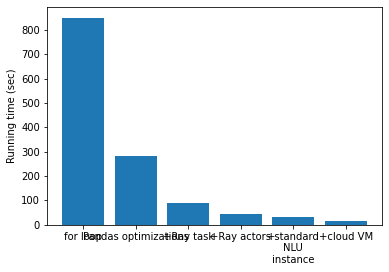

In [24]:
import matplotlib.pyplot as plt
time_data = {
    # All times in seconds
    "for loop": 852,
    "Pandas optimizations": 283,
    "+Ray task": 90,
    "+Ray actors": 45, 
    "+standard\nNLU\ninstance": 30,   
    # Separate run on iRIS machine with 56 cores.
    "+cloud VM": 15,
}

plt.bar(time_data.keys(), time_data.values())
plt.ylabel("Running time (sec)")
plt.show()

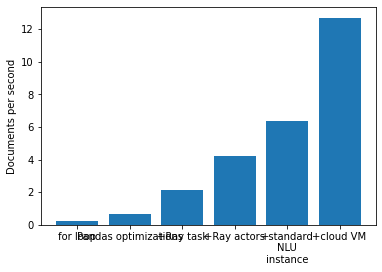

In [25]:
num_docs = len(articles.index)
docs_per_sec = {
    k: num_docs/v for k, v in time_data.items()
}
plt.bar(docs_per_sec.keys(), docs_per_sec.values())
plt.ylabel("Documents per second")
plt.show()